In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def jac_to_ic(rg,rp,theta,m1,m2,m3):
    
    thrad=np.radians(theta)

    mred2 = m2/(m2+m3)
    mred3 = m3/(m2+m3)

    r12=np.sqrt(rg*rg + mred3*mred3*rp*rp + 2.0*rg*mred3*rp*np.cos(thrad))
    r13=np.sqrt(rg*rg + mred2*mred2*rp*rp - 2.0*rg*mred2*rp*np.cos(thrad))
    r23=rp

    return r12,r13,r23

def ic_to_jac(r12,r13,r23,m1,m2,m3):

    mred2 = m2/(m1+m2)
    d1 = mred2*r13
    cbeta = (r12*r12+r13*r13-r23*r23)/(2.0*r12*r13)

    rp = r13
    rg = np.sqrt(r12*r12+d1*d1-2.0*r12*d1*cbeta)
    ctheta = (r12*r12-d1*d1-rg*rg)/(-2.0*rg*d1)
    theta = np.degrees(np.arccos(ctheta))

    return rg,rp,theta

def transform_coords(rg,rp,theta,m1,m2,m3):

    r12,r13,r23=jac_to_ic(rg,rp,theta,m1,m2,m3)
    rgp,rpp,thetap=ic_to_jac(r12,r13,r23,m1,m2,m3)

    return rgp,rpp,thetap

In [3]:
print(transform_coords(2.65,1.4,90,30.9737620,2.0141017778,2.0141017778))

(np.float64(2.5966922514026716), np.float64(2.7408940147331493), np.float64(148.58264539291366))


In [4]:
path_ex = "/home/jorgebdelafuente/Doctorado/Quantics/PH2p_1TApp/exact_test/"
path_ex = "/home/jorgebdelafuente/Doctorado/Quantics/PH2p_1TApp/ph2p/psitrans/"
path_ex = "/home/jorgebdelafuente/Doctorado/Quantics/PH2p_1TApp/ph2p/trnsf_psi/"

# psi_twocoords = np.loadtxt(path_ex+"grid_test.dat")
# rpgrid = np.loadtxt(path_ex+"rpgrid.dat",skiprows=11)[:,1]
# rggrid = np.loadtxt(path_ex+"rggrid.dat",skiprows=11)[:,1]
# thgrid = np.loadtxt(path_ex+"thgrid.dat",skiprows=11)[:,1]
# print(rpgrid)

In [7]:
blocks = []

with open(path_ex+"grid_test.dat") as f:
    current_block = []
    for line in f:
        s = line.strip()
        if not s: 
            if current_block:   
                blocks.append(current_block)
                current_block = []
        else:
            current_block.append([float(x) for x in s.split()])
    if current_block:
        blocks.append(current_block)

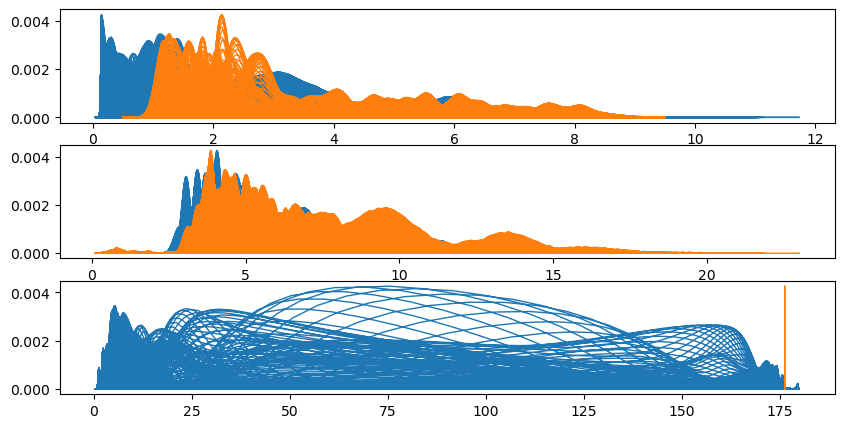

In [14]:
fig, ax = plt.subplots(3,figsize=(10,5))

test=np.array(blocks[00])
norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
# norm = test[:,6]
rpt,rgt,tht = transform_coords(test[:,3],test[:,4],test[:,5],30.9737620,2.0141017778,2.0141017778)
ax[0].plot(test[:,0],norm,lw=1)
# ax[0].plot(rpt,norm,lw=1,alpha=0.15)
ax[0].plot(test[:,3],norm,lw=1)

ax[1].plot(test[:,1],norm,lw=1)
# ax[1].plot(rgt,norm,lw=1,alpha=0.15)
ax[1].plot(test[:,4],norm,lw=1)

ax[2].plot(test[:,2],norm,lw=1)
# ax[2].plot(tht,norm,lw=1,alpha=0.15)
ax[2].plot(test[:,5],norm,lw=1)

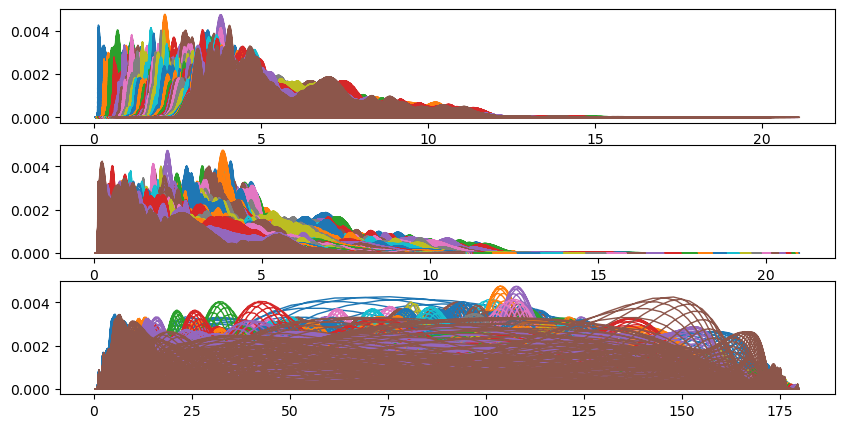

In [9]:
fig1, ax1 = plt.subplots(3,figsize=(10,5))

for i in range(len(blocks)):
    test=np.array(blocks[i])
    norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
    # norm = test[:,6]
    ax1[0].plot(test[:,0],norm,lw=1)
    ax1[1].plot(test[:,1],norm,lw=1)
    ax1[2].plot(test[:,2],norm,lw=1)

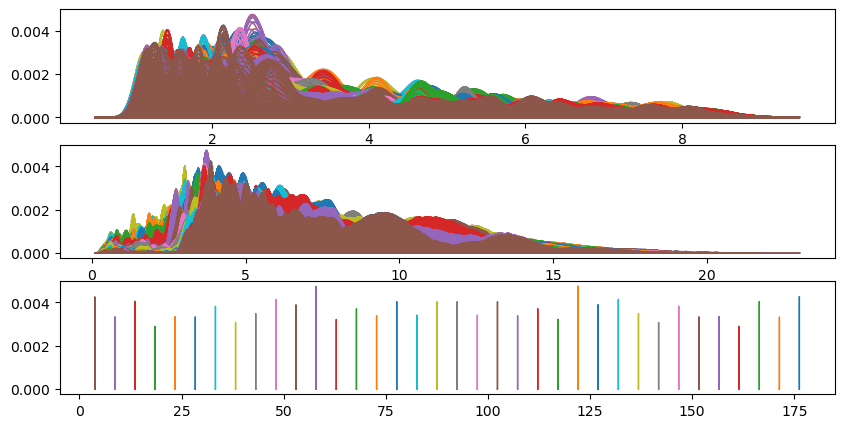

In [ ]:
fig1, ax1 = plt.subplots(3,figsize=(10,5))

for i in range(len(blocks)):
    test=np.array(blocks[i])
    norm = np.sqrt(test[:,6]*test[:,6] + test[:,7]*test[:,7])
    # norm = test[:,6]
    ax1[0].plot(test[:,3],norm,lw=1)
    ax1[1].plot(test[:,4],norm,lw=1)
    ax1[2].plot(test[:,5],norm,lw=1)

In [11]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

def herm_pols(n, x):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 2*x
    else:
        return herm_pols(n-1, x) * 2 * x - 2 * n * herm_pols(n-2, x)

def ho_modes(r, mu, omega, r0=0.0, hbar=1.0, nv=10):
    
    x = r-r0
    a = np.sqrt(mu*omega/hbar)
    ex = a*x

    phi = np.zeros((len(x), nv))

    for i in range(nv):  
        env = 0.5*omega*x*x
        prefact = np.sqrt(a/(np.sqrt(np.pi)*(2**i)*factorial(i)))
        expfact = np.exp((-ex**2)/2)
        hpol = herm_pols(i, ex)
        phi[:,i] = prefact*expfact*hpol

    return env, phi

def trapz_manual(f, dx):
    """Integración trapezoidal simple sobre un vector 1D f."""
    return dx * (0.5*f[0] + f[1:-1].sum() + 0.5*f[-1])


[ 0.1  0.1  0.1 ... 23.  23.  23. ]
0.023498690000000044 0.05971316999999998
[0.49984365 0.07024055 0.09023867 0.08619351 0.0763851  0.04586009
 0.04143885 0.04404274 0.04575684]


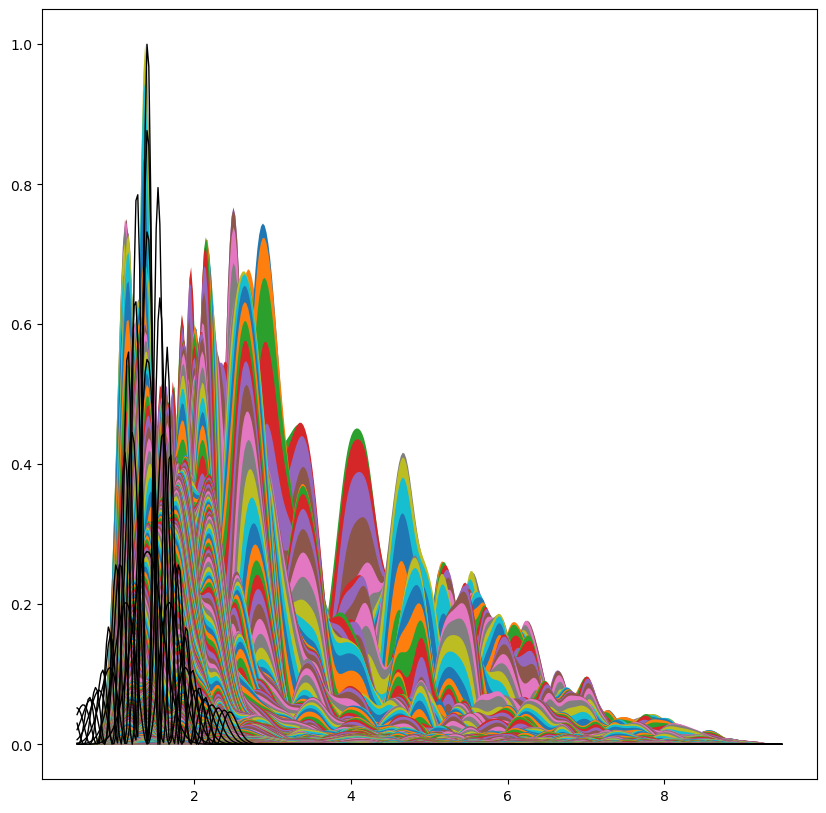

In [12]:
nr,nR = 384,768
r = np.array(blocks[17])[:nr,3]
R = np.array(blocks[17])[:,4]
print(R)
# r: vector 1D de la rejilla radial (longitud nr) -> NO lo cojas de blocks
amu_to_me = 1822.888486
mD = 2.0141017778
mu = ((mD*mD)/(mD+mD))*amu_to_me
nu_cm = 3115.0/2               # cm^-1 (test)
omega = nu_cm * 4.556335e-6   # a.u. (Hartree), ~0.0142
nv = 9

E, phi = ho_modes(r, mu=mu, omega=omega, r0=1.4, nv=nv)  # phi: (nr, nv)

dr = r[1] - r[0]
dR = R[nR] - R[0]

# for m in range(0,len(blocks)-1,4):
for m in [17]:
    M = np.array(blocks[m])              # M: (nR, nr)
    mat_psi_Norm = np.zeros((nR,nr))
    maxnorm = max(np.sqrt(M[:,6]*M[:,6]+M[:,7]*M[:,7]))
    counter = 0
    for i in range(nR):
        for j in range(nr):
            mat_psi_Norm[i,j] = np.sqrt(M[counter,6]*M[counter,6]+M[counter,7]*M[counter,7])
            counter += 1
        
    print(dr,dR)
    norm_total = np.sum(mat_psi_Norm**2)*dr*dR
    mat_psi = mat_psi_Norm/(norm_total**0.5)
    
    # mat_psi = mat_psi_Norm
    # print(mat_psi)
    A = np.zeros((nR,nv))

    A = np.einsum("ij,jk->ik", mat_psi, phi)*dr
    Pv = np.einsum("ik,ik->k", A, A)*dR
    sumPv = np.sum(Pv)

    for i in range(len(Pv)):
        Pv[i] = Pv[i]/sumPv

    print(Pv)
    fig2, ax2 = plt.subplots(figsize=(10,10))

    maxpsi = np.max(mat_psi)
    mat_psi /= maxpsi
    # normwf = np.sqrt(M[:,6]*M[:,6]+M[:,7]*M[:,7])
    # ax2.plot(R,A)
    phisq = abs(phi*phi)
    maxphi = np.max(phisq)
    phisq /= maxphi
    zeros = np.zeros((nR,nr))
    for i in range(nR):
        ax2.fill_between(r,zeros[i,:],mat_psi[i,:],lw=1)
        # ax2.plot(r,mat_psi[i,:],lw=1)
    # ax2.plot(M[:,3],np.sqrt(M[:,6]*M[:,6]+M[:,7]*M[:,7]),lw=1)
    for i in range(nv):
        ax2.plot(r,phisq[:,i],lw=1,color="black")
        # ax2.plot(r,phisq[:,i]*Pv[i],lw=1,color="black")
    # ax2.plot(np.array(blocks[20])[:,4],norm)

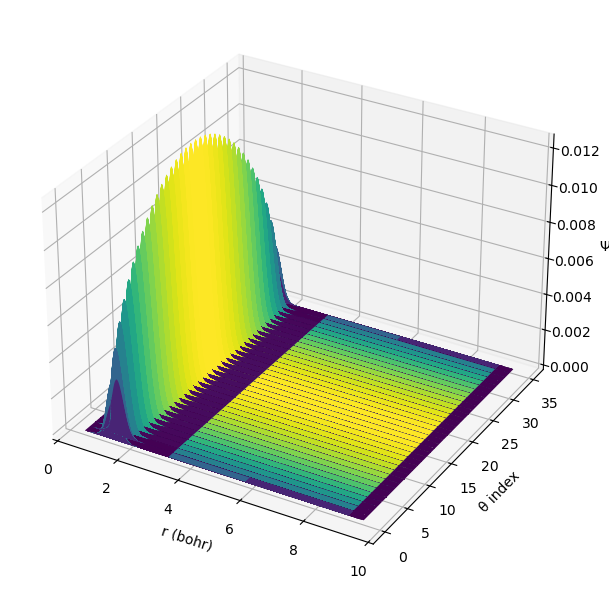

In [53]:
# Convertir a numpy
blocks_array = [np.array(b) for b in blocks]

# Construir rejilla X-Y
# X: r, Y: theta (un valor por bloque)
rp = blocks_array[30][:, 3]                    
# Rg = blocks_array[30][:, 4]                    
theta_vals = np.arange(len(blocks_array))    

Rp, TH = np.meshgrid(rp, theta_vals)
# rp, TH = np.meshgrid(Rg, theta_vals)
# rp, rg = np.meshgrid(rp, Rg)

# Construir matriz Z = psi(r,θ)
Z = np.zeros_like(Rp)
for i, block in enumerate(blocks_array):
    Z[i, :] = np.sqrt(block[:, 6]*block[:,6]+block[:,7]*block[:,7])     # columna que contiene psi

# Graficar superficie
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(Rp, TH, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel("r (bohr)")
ax.set_ylabel("θ index")
ax.set_zlabel("Ψ")

# fig.colorbar(surf, shrink=0.7)
fig.tight_layout()
plt.show()